In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

Note:
SST-8 and SST-3 classifications are provided for each protein sequence. SST-8 consists of 8 categories of secondary structures based upon geometric rules of classification. SST-3 gathers similar SST-8 catagories into a simpler and more general set of structures.
SST-8 Category	Description	SST-3 Category      Type
E	        	E                               β-strand
B	        	E                               β-bridge
H	       	    H                               α-helix	
G	            H                               3-helix	
I	    	    H                               π-helix
C	        	C                               Loops and irregular elements
T	            C                               Turn
S	            C                               Bend

In [2]:
fpath = '/Users/liyao/Desktop/Tsuda_Lab/Source_code/Neural_network/protein_ss/2022-08-03-ss.cleaned.csv'
df = pd.read_csv(fpath)
df = df.dropna()
df = df.drop_duplicates(subset=['seq'])
df = df[(df['len'] >= 100) & (df['len'] <= 1000)]
df = df[df['has_nonstd_aa'] == False]   
print(df.shape)
display(df.head(-5))

(90888, 7)


,pdb_id,chain_code,seq,sst8,sst3,len,has_nonstd_aa
70465,1A5K,A,MELTPREKDKLLLFTAALVAERRLARGLKLNYPESVALISAFIMEG...,CCCCHHHHHHHHHHHHHHHHHHHHHTTCCBCHHHHHHHHHHHHHHH...,CCCCHHHHHHHHHHHHHHHHHHHHHCCCCECHHHHHHHHHHHHHHH...,100,False
70470,1A9B,B,MIQRTPKIQVYSRHPAENGKSNFLNCYVSGFHPSDIEVDLLKNGER...,CCCBCCEEEEEESSCCCTTSCEEEEEEEEEEBSSCEEEEEEETTEE...,CCCECCEEEEEECCCCCCCCCEEEEEEEEEEECCCEEEEEEECCEE...,100,False
70473,1AO7,B,MIQRTPKIQVYSRHPAENGKSNFLNCYVSGFHPSDIEVDLLKNGER...,CCCBCCEEEEEESSCCCTTSCEEEEEEEEEEBSSCCEEEEEETTEE...,CCCECCEEEEEECCCCCCCCCEEEEEEEEEEECCCCEEEEEECCEE...,100,False
70474,1AUE,A,ELIRVAILWHEMWHEGLEEASRLYFGERNVKGMFEVLEPLHAMMER...,CCCCCCCCHHHHHHHHHHHHHHHHHTTCCHHHHHHHHHHHHHHHHT...,CCCCCCCCHHHHHHHHHHHHHHHHHCCCCHHHHHHHHHHHHHHHHC...,100,False
70480,1BZ9,B,MIQKTPQIQVYSRHPPENGKPNILNCYVTQFHPPHIEIQMLKNGKK...,CCCBCCBCCEEESSCCCTTSCEEEEEEEEEEBSSCEEEEEEETTEE...,CCCECCECCEEECCCCCCCCCEEEEEEEEEEECCCEEEEEEECCEE...,100,False
...,...,...,...,...,...,...,...
471791,5OOQ,A,GPDSMLADSFEQEASREVDASKGLTNSETLQVEQDGKVRLSHQVRH...,CCCCCEECCCEEEEEEEEECCCTTSSSCSSCCCTTSEEEEEEEEEE...,CCCCCEECCCEEEEEEEEECCCCCCCCCCCCCCCCCEEEEEEEEEE...,998,False
471793,2BYV,E,GSPGIPMVAAHAAHSQSSAEWIACLDKRPLERSSEDVDIIFTRLKG...,CCCCCCCCCCCCCCCCCCCCCHHHHHSCTTTCCHHHHHHHHHHHHH...,CCCCCCCCCCCCCCCCCCCCCHHHHHCCCCCCCHHHHHHHHHHHHH...,999,False
471794,4F7Z,A,GSPGIPMVAAHAAHSQSSAEWIACLDKRPLERSSEDVDIIFTRLKG...,CCCCCCCCCCCCCCCCCSCCHHHHHHSCSSSCCHHHHHHHHHHHTT...,CCCCCCCCCCCCCCCCCCCCHHHHHHCCCCCCCHHHHHHHHHHHCC...,999,False
471795,6I2X,A,TLQKKIEEIAAKYKHSVVKKCCYDGACVNNDETCEQRAARISLGPR...,CCCSHHHHHHHTTSSCTTHHHHHTTSSCCTTSCTTTTTTTCCSCHH...,CCCCHHHHHHHCCCCCCCHHHHHCCCCCCCCCCCCCCCCCCCCCHH...,999,False


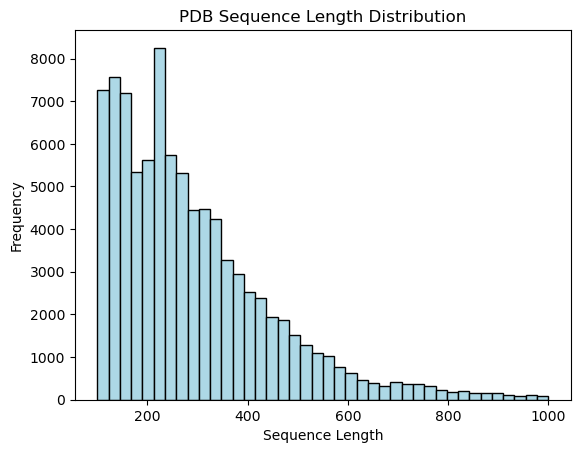

In [59]:
plt.hist(df['len'], bins=40, color='lightblue', edgecolor='black')
plt.title(f'PDB Sequence Length Distribution')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

In [3]:
AA_array = {
    "A": [-0.591, -1.302, -0.733,  1.570, -0.146],
    "C": [-1.343,  0.465, -0.862, -1.020, -0.255],
    "D": [ 1.050,  0.302, -3.656, -0.259, -3.242],
    "E": [ 1.357, -1.453,  1.477,  0.113, -0.837],
    "F": [-1.006, -0.590,  1.891, -0.397,  0.412],
    "G": [-0.384,  1.652,  1.330,  1.045,  2.064],
    "H": [ 0.336, -0.417, -1.673, -1.474, -0.078],
    "I": [-1.239, -0.547,  2.131,  0.393,  0.816],
    "K": [ 1.831, -0.561,  0.533, -0.277,  1.648],
    "L": [-1.019, -0.987, -1.505,  1.266, -0.912],
    "M": [-0.663, -1.524,  2.219, -1.005,  1.212],
    "N": [ 0.945,  0.828,  1.299, -0.169,  0.933],
    "P": [ 0.189,  2.081, -1.628,  0.421, -1.392],
    "Q": [ 0.931, -0.179, -3.005, -0.503, -1.853],
    "R": [ 1.538, -0.055,  1.502,  0.440,  2.897],
    "S": [-0.228,  1.399, -4.760,  0.670, -2.647],
    "T": [-0.032,  0.326,  2.213,  0.908,  1.313],
    "V": [-1.337, -0.279, -0.544,  1.242, -1.262],
    "W": [-0.595,  0.009,  0.672, -2.128, -0.184],
    "Y": [ 0.260,  0.830,  3.097, -0.838,  1.512]
}## adopted from Atchley et al. (2005): https://www.pnas.org/doi/epdf/10.1073/pnas.0408677102

for key, value in AA_array.items():
    value = list(map(str,value))
    AA_array[key] = value

In [4]:
## utlis part ##

## split whole pdb sequence into consecutive ss parts ##
def split_seq_ss(sequence, sst8):
    # Validate input types
    if not isinstance(sequence, str) or not isinstance(sst8, str):
        return False
    
    # Initialize variables for tracking the current segment and secondary structure
    ss_consecutive_dict = {}
    current_segment = sequence[0]
    current_ss = sst8[0]

    def segment_criterion(segment, ss):
        segment_len = len(segment)
        min_length = {
            'E': 4,  # beta-sheet
            'H': 4,  # alpha-helix
            'G': 3,  # 3-helix
            'I': 5,  # π-helix
            'T': 4,  # Turn
            'S': 4,  # Bend
            'C': 3,  # 'C' (Loops and irregular elements)
            'B': 3   # beta-bridge
        }
        return ss in min_length and segment_len >= min_length[ss]

    # Iterate through the sequence and secondary structure
    for char, ss_char in zip(sequence[1:], sst8[1:]):  # Start from the second character
        if ss_char == current_ss:
            # If the current ss is the same as the previous, add the character to the current segment
            current_segment += char
        else:
            if segment_criterion(current_segment, current_ss):
                if current_ss not in ss_consecutive_dict.keys():
                    ss_consecutive_dict[current_ss] = []
                ss_consecutive_dict[current_ss].append(current_segment)
            current_ss = ss_char
            current_segment = char
    if segment_criterion(current_segment, current_ss):
        if current_ss not in ss_consecutive_dict.keys():
                ss_consecutive_dict[current_ss] = []
        ss_consecutive_dict[current_ss].append(current_segment)
    return ss_consecutive_dict

## one-hot encoding of sequence ##
def seq_one_hot_encoding(sequence):
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    aa_to_index = {aa: index for index, aa in enumerate(amino_acids)}
    encoding_sum = [0] * len(amino_acids)
    for aa in sequence:
        if aa in aa_to_index:
            encoding_sum[aa_to_index[aa]] += 1
    return encoding_sum

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))

aa_list = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
def seq_encode(sequence):
    encoded_sequence = []
    for aa in sequence:
        one_hot = one_of_k_encoding(aa, aa_list)  # One-hot encoding of aa
        aa_property = AA_array[aa]  # Properties of aa
        encoded_aa = one_hot + aa_property  # Concatenate one-hot encoding and properties
        encoded_sequence.append(encoded_aa)
    return np.array(encoded_sequence, dtype='float64') 

In [5]:
## generate segements with same ss type from pdb sequence ##
ss_sequences = {}

for index, row in df.iterrows():
    seq = row['seq'].strip()
    ss = row['sst8'].strip()
    ss_consecutive_dict = split_seq_ss(seq, ss)

    for ss_type, sequences in ss_consecutive_dict.items():
        if ss_type not in ss_sequences:
            ss_sequences[ss_type] = []
        ss_sequences[ss_type].extend(sequences)

In [ ]:
# Calculate lengths and store in a dictionary
ss_lengths = {ss_type: [len(seq) for seq in sequences] for ss_type, sequences in ss_sequences.items()}
all_lengths = [length for lengths in ss_lengths.values() for length in lengths]
min_length = min(all_lengths)
max_length = max(all_lengths)

bin_width = 1
bins = np.arange(min_length, max_length + bin_width, bin_width)

num_ss_types = len(ss_lengths)
fig, axs = plt.subplots(num_ss_types, figsize=(6, 3 * num_ss_types))

xlims = {
    'B': (0, 20),
    'C': (0, 60),
    'H': (0, 60),
    'G': (0, 20),
    'E': (0, 25), 
    'S': (0, 20),
    'T': (0, 20),
    'I': (0, 20)
}
for ax, (ss_type, lengths) in zip(axs, ss_lengths.items()):
    ax.hist(lengths, bins=bins, color='lightblue', edgecolor='black')
    ax.set_title(f'Sequence Length Distribution for {ss_type}')
    ax.set_xlabel('Sequence Length')
    ax.set_ylabel('Frequency')

    if ss_type in xlims:
        ax.set_xlim(xlims[ss_type])

plt.tight_layout()
plt.show()

filtered_ss_sequences = {}
for ss_type, sequences in ss_sequences.items():
    length_range = xlims.get(ss_type, (0, float('inf')))
    filtered_sequences = [seq for seq in sequences if length_range[0] <= len(seq) <= length_range[1]]
    filtered_ss_sequences[ss_type] = filtered_sequences
ss_sequences = filtered_ss_sequences

In [1]:
import numpy as np
import random
from itertools import islice
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

x = []
y = []
max_len = 60
print(max_len)

for ss_type, sequences in ss_sequences.items():
    for seq in sequences:
        if len(seq) > max_len:
            continue
        x_encoded = seq_encode(seq)  # Encode each sequence
        padded_seq = pad_sequences([x_encoded], maxlen=max_len, padding="post", dtype="float64")
        x.append(padded_seq)
        y.append(ss_type)

x = np.array(x).reshape(-1, max_len, len(x[0][0][0])) 
y = np.array(y)
print(x.shape)
print(y.shape)

combined = list(zip(x, y))
random.shuffle(combined)
x[:], y[:] = zip(*combined)

encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

np.save('/Users/liyao/Desktop/Tsuda_Lab/Source_code/Neural_network/protein_ss/x_feature.npy', x[:200000,:,:])
np.save('/Users/liyao/Desktop/Tsuda_Lab/Source_code/Neural_network/protein_ss/y_feature.npy', y_encoded[:200000])


'''
x_train, x_test, y_train, y_test = train_test_split(x, y_encoded, test_size=0.2, random_state=42)

print("Train x set shape:", x_train.shape)
print("Test x set shape:", x_test.shape)
print("Train y set shape:", y_train.shape)
print("Test y set shape:", y_test.shape)
'''

60


NameError: name 'ss_sequences' is not defined

In [ ]:
print(y)

In [66]:
print("Train x set shape:", x_train.shape)
print("Test x set shape:", x_test.shape)
print("Train y set shape:", y_train.shape)
print("Test y set shape:", y_test.shape)
print(x_train[:3])
print(y_train[:3])

Train x set shape: (1974616, 20)
Test x set shape: (493654, 20)
Train y set shape: (1974616, 8)
Test y set shape: (493654, 8)
[[1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0]
 [1 0 0 1 0 0 0 0 0 1 1 2 0 0 0 1 0 0 0 0]
 [0 0 0 2 1 1 0 3 1 1 0 1 1 0 0 0 1 0 0 0]]
[[0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]]


In [67]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

# Convert data to PyTorch tensors
x_train_tensor = torch.FloatTensor(x_train)
y_train_tensor = torch.FloatTensor(y_train)
x_test_tensor = torch.FloatTensor(x_test)
y_test_tensor = torch.FloatTensor(y_test)

# Create datasets and dataloaders
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the model
class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_size, 50)
        self.layer2 = nn.Linear(50, output_size)
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.layer2(x)
        return x

model = SimpleNN(x_train.shape[1], y_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
for epoch in range(10):  # number of epochs
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, torch.max(labels, 1)[1])
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/10], Loss: {loss.item():.4f}')


Epoch [1/10], Loss: 0.4008
Epoch [2/10], Loss: 0.9145
Epoch [3/10], Loss: 1.1134
Epoch [4/10], Loss: 0.5206
Epoch [5/10], Loss: 0.8139
Epoch [6/10], Loss: 0.8545
Epoch [7/10], Loss: 0.9822
Epoch [8/10], Loss: 0.7400
Epoch [9/10], Loss: 0.6433
Epoch [10/10], Loss: 0.8025


In [68]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == torch.max(labels, 1)[1]).sum().item()

print(f'Accuracy of the model on the test set: {100 * correct / total}%')


Accuracy of the model on the test set: 67.12616528985889%
